In [1]:
import tensorflow as tf

In [3]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, BatchNormalization, ZeroPadding2D, Activation, add
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob

In [4]:
# re-size all the images
IMAGE_SIZE = [224,224]

# training config
epochs = 16
batch_size = 128

In [13]:
!wget -nc https://lazyprogrammer.me/course_files/blood_cell_images.zip

--2023-08-06 16:19:13--  https://lazyprogrammer.me/course_files/blood_cell_images.zip
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109834540 (105M) [application/zip]
Saving to: ‘blood_cell_images.zip’

blood_cell_images.z 100%[===================>] 104.75M  47.0MB/s    in 2.2s    

2023-08-06 16:19:16 (47.0 MB/s) - ‘blood_cell_images.zip’ saved [109834540/109834540]



In [14]:
!unzip -nq blood_cell_images.zip

In [15]:
!ls

blood_cell_images  blood_cell_images.zip  __MACOSX  sample_data


In [16]:
train_path = 'blood_cell_images/TRAIN'
valid_path = 'blood_cell_images/TEST'

In [18]:
# useful for getting number of files
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')

In [19]:
# useful for getting the number of classes
folders = glob(train_path + '/*')

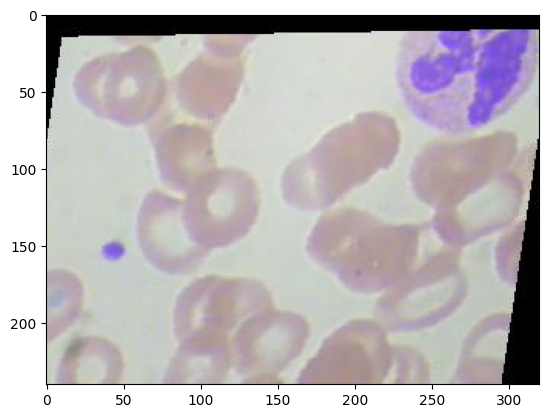

In [20]:
# llok at an image for fun
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

In [21]:
def identity_block(input_, kernel_size, filters):
    f1, f2, f3 = filters

    x = Conv2D(f1, (1, 1),
               # kernel_initializer='he_normal'
               )(input_)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(f2, kernel_size, padding='same',
               # kernel_initializer='he_normal
               )(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(f3, (1, 1),
               # kernel_initializer='he_normal
               )(x)
    x = BatchNormalization()(x)

    x = add([x, input_])
    x = Activation('relu')(x)
    return x

In [ ]:
def conv_block(input,
               kernel_size,
               filters,
               strides=(2,2)):
    f1, f2, f3 = filters

    x = Conv2D(f1, (1, 1), strides=strides,
               # kernel_initializer='he_normal'
               )(input_)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(f2, kernel_size, padding='same',
               # kernel_initializer='he_normal'
               )(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(f3, (1, 1),
               # kernel_initializer='he_normal'
               )(x)